# Gender classification using Convolutional Neural Network (ConvNet)

###### import the Zip file from Google drive

importing zip file in google Colaboratory stored in google drive can be done by two methods: 

1) The first one:

Open the link in a new tab-> you will get a code - copy that back into the prompt you now have access to google drive check:


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Then unzip your file using the following command:



In [3]:
!unzip "/content/gdrive/MyDrive/FaceApp_NN/model.zip" 


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: model/data/train/male/male_002006.jpg  
  inflating: model/data/train/male/male_002007.jpg  
  inflating: model/data/train/male/male_002008.jpg  
  inflating: model/data/train/male/male_002009.jpg  
  inflating: model/data/train/male/male_002010.jpg  
  inflating: model/data/train/male/male_002011.jpg  
  inflating: model/data/train/male/male_002012.jpg  
  inflating: model/data/train/male/male_002013.jpg  
  inflating: model/data/train/male/male_002014.jpg  
  inflating: model/data/train/male/male_002015.jpg  
  inflating: model/data/train/male/male_002016.jpg  
  inflating: model/data/train/male/male_002017.jpg  
  inflating: model/data/train/male/male_002018.jpg  
  inflating: model/data/train/male/male_002019.jpg  
  inflating: model/data/train/male/male_002020.jpg  
  inflating: model/data/train/male/male_002021.jpg  
  inflating: model/data/train/male/male_002022.jpg  
  inflating: model/da

2) The second method is the following: 

First you install and import libraries

```
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
```

Then you authenticate yourself and connect to Google Drive


```
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
```
Then you download the file your_data.zip from Google Drive to Colab:

```
fid = drive.ListFile({'q':"title='your_data.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('your_data.zip')
```

**From here you can unzip them and do whatever training you need.**








### 1) Import the libraries

In [ ]:
# Update the tensorflow
# !pip install --upgrade tensorflow

# The tensorflow version in this project is : 3.7.0

In [4]:
# import libraries 
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)
print("Done!")

2.7.0
Done!


### 2) Load the dataset from directories

In [7]:
###### 1) Upload dataset from directories
DATADIR = "model/data/train/"
CATEGORIES = ['female', 'male']

IMG_SIZE = 150
batch_size= 32 # Others batch sizes 64, 128, and 256.

ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(DATADIR,
    labels="inferred",
    label_mode = "binary", # int or categorical
    #class_names = CATEGORIES,
    #color_mode ="grayscale", # Uncomment thi to wirk in the gray scale
    batch_size = batch_size,
    image_size = (IMG_SIZE,IMG_SIZE), # reshape if not in this size
    shuffle = True,
    seed= 123, # to maintain the same data when spliyying the data
    validation_split = 0.2,
    subset = "training",
)


ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(DATADIR,
    labels="inferred",
    label_mode = "binary", # Other label modes are: int or categorical
    #class_names = CATEGORIES,
    #color_mode ="grayscale", # Uncomment thi to wirk in the gray scale
    batch_size = batch_size,
    image_size = (IMG_SIZE,IMG_SIZE), # reshape if not in this size
    shuffle = True,
    seed= 123, # to maintain the same results for different runs and data when splitting the data 
    validation_split = 0.2,
    subset = "validation",
)

print("Done!")

Found 14000 files belonging to 2 classes.
Using 11200 files for training.
Found 14000 files belonging to 2 classes.
Using 2800 files for validation.
Done!


In [8]:
class_names = ds_train_.class_names
class_names

['female', 'male']

In [28]:
#images, labels = ds_train_.take(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


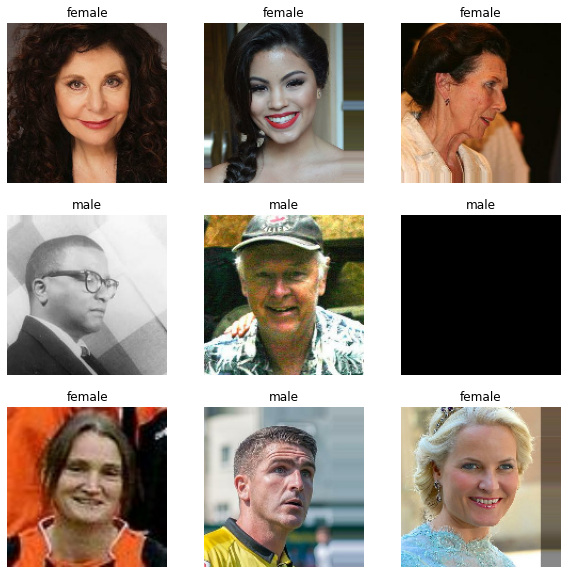

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for images, labels in ds_train_.take(2):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")


### 3) Preprocess the data and create Checkpoints

###### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

+ **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
+ **Dataset.prefetch** overlaps data preprocessing and model execution while training.

> ***For more details, please visit***  [Tensorflow tutorials: classificattion](https://www.tensorflow.org/tutorials/images/classification)

In [29]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

#def standardize(image_data):
        #image_data -= np.mean(image_data, axis=0)
        #image_data /= np.std(image_data, axis=0)
       # return image_data

AUTOTUNE = tf.data.experimental.AUTOTUNE # Search for this 
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# save checkpoints during training

checkpoint_path = "/content/model/Pretrained model/checkpoints_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

print("Done!")

Done!


### 4) Create the model

The Sequential model consists of three basic convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them (the base) followed by a head of Dense layers. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). 

> *NP: This model has not been tuned for high accuracy.*


In [ ]:
IMG_SIZE = 150
batch_size= 32 # Others batch sizes 64, 128, and 256.

model = keras.Sequential([
    # Rescaling the images to [0,1]
    layers.Rescaling(1./255, input_shape=[IMG_SIZE,IMG_SIZE, 3]),
    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  ), # Please recheck the number of channels in your input images
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 128)      

### 5) Compile the model

I choosed the tf.keras.optimizers.Adam optimizer and binary_crossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
# Compile and fit the model
#learning_rate=0.001 
optimizer = tf.keras.optimizers.Adam()#learning_rate= 0.05, epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

print("Done!")


Done!


### 6) train the model 



In [ ]:
batch_size = 30
epochs = 11 # then use 25 and 50

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    batch_size= batch_size,  # Others batch sizes 64, 128, and 256.
    epochs=epochs,
    callbacks=[cp_callback]  # Pass callback to training
)

print("Congratualation the model learned!")

Epoch 1/11
350/350 [==============================] - ETA: 0s - loss: 0.6402 - binary_accuracy: 0.6406
Epoch 00001: saving model to /content/model/Pretrained model/checkpoints_training/cp.ckpt
350/350 [==============================] - 842s 2s/step - loss: 0.6402 - binary_accuracy: 0.6406 - val_loss: 0.5753 - val_binary_accuracy: 0.7029
Epoch 2/11
350/350 [==============================] - ETA: 0s - loss: 0.5528 - binary_accuracy: 0.7231
Epoch 00002: saving model to /content/model/Pretrained model/checkpoints_training/cp.ckpt
350/350 [==============================] - 823s 2s/step - loss: 0.5528 - binary_accuracy: 0.7231 - val_loss: 0.5587 - val_binary_accuracy: 0.7271
Epoch 3/11
350/350 [==============================] - ETA: 0s - loss: 0.5017 - binary_accuracy: 0.7570
Epoch 00003: saving model to /content/model/Pretrained model/checkpoints_training/cp.ckpt
350/350 [==============================] - 822s 2s/step - loss: 0.5017 - binary_accuracy: 0.7570 - val_loss: 0.5322 - val_binary_

### 7) Plot learning curves

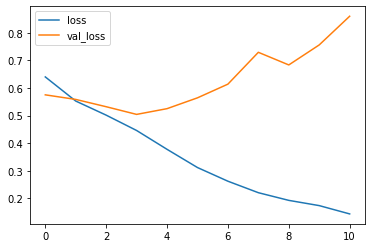

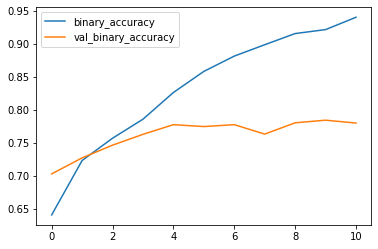

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

### 8) Creating the model with data augmetaion:



```
# Model with data augumentation

from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    
    #preprocessing.RandomContrast(factor=0.3),
   # preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    #preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    #preprocessing.RandomWidth(factor=0.15), # horizontal stretch
   # preprocessing.RandomRotation(factor=0.20),
    #preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


# Compile and fit the model 
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
```



In [30]:
# Second Model:

# Model with data augumentation

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


batch_size = 30
epochs = 11 # then use 25 and 50 (Due to the lake of the computational power I used 11. If you have it, Use 50 epochs which is better for this model)

model2 = keras.Sequential([
    layers.InputLayer(input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.Rescaling(1./255),
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    #preprocessing.RandomContrast(factor=0.3),
   # preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    #preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    #preprocessing.RandomWidth(factor=0.15), # horizontal stretch
   # preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


# Compile and fit the model 
optimizer2 = tf.keras.optimizers.Adam(epsilon=0.01)
model2.compile(
    optimizer=optimizer2,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history2 = model2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
)

print("Done!")

Epoch 1/11
350/350 [==============================] - 1962s 6s/step - loss: 0.7085 - binary_accuracy: 0.5314 - val_loss: 0.7382 - val_binary_accuracy: 0.5021
Epoch 2/11
350/350 [==============================] - 1913s 5s/step - loss: 0.7043 - binary_accuracy: 0.5984 - val_loss: 0.6297 - val_binary_accuracy: 0.6704
Epoch 3/11
350/350 [==============================] - 1901s 5s/step - loss: 0.7871 - binary_accuracy: 0.6315 - val_loss: 0.6295 - val_binary_accuracy: 0.6807
Epoch 4/11
350/350 [==============================] - 1892s 5s/step - loss: 0.6233 - binary_accuracy: 0.6617 - val_loss: 0.6016 - val_binary_accuracy: 0.6904
Epoch 5/11
350/350 [==============================] - 1884s 5s/step - loss: 0.6078 - binary_accuracy: 0.6752 - val_loss: 0.6504 - val_binary_accuracy: 0.6164
Epoch 6/11
350/350 [==============================] - 1871s 5s/step - loss: 0.5918 - binary_accuracy: 0.6889 - val_loss: 0.5583 - val_binary_accuracy: 0.7332
Epoch 7/11
350/350 [==============================] 

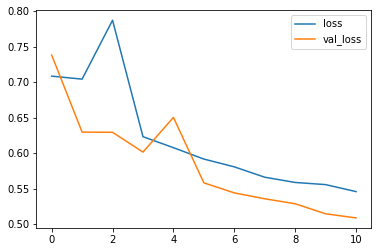

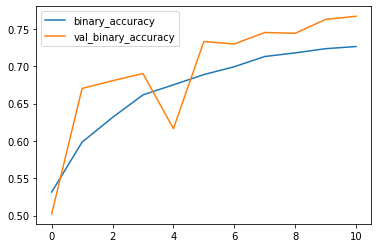

In [53]:
# Plot learning curves
import pandas as pd
history_frame2 = pd.DataFrame(history2.history)
history_frame2.loc[:, ['loss', 'val_loss']].plot()
history_frame2.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

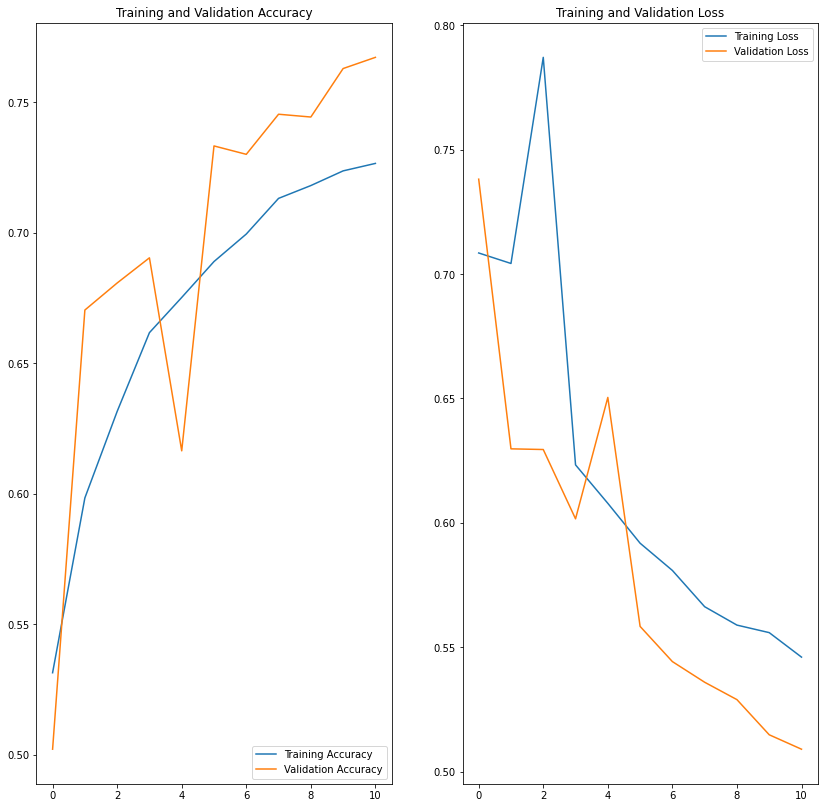

In [56]:
# Another way to visualize the trainning accuracy 
acc = history2.history['binary_accuracy']
val_acc = history2.history['val_binary_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9) Save and load the trained model

Setup
Install and import TensorFlow and dependencies:


```
pip install pyyaml h5py  # Required to save models in HDF5 format

```



> Model progress can be saved during and after training.

In [33]:
# Installs and imports libraries:
!pip install pyyaml h5py

In [50]:
#from tensorflow import keras

dir_pretrainedModel = "/model/Pretrained_model"
#dir_pretrainedModel = "/content/model/Pretrained model"
filename = dir_pretrainedModel + '/' +  'my_model2.h5'
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model2.save(filename)


# Recreate the exact same model, including its weights and the optimizer
new_model2 = tf.keras.models.load_model(filename)

new_model2




### 10) Prediction

Import new image to test the performance of the proposed model:


In [111]:
Gender_url = "./model/data/test/male_000281.jpg"
#Gender_path = tf.keras.utils.get_file(Gender_url)

img = tf.keras.utils.load_img(
    Gender_url, target_size=(IMG_SIZE, IMG_SIZE)
)

img_array= tf.keras.utils.img_to_array(img)
img_array= tf.expand_dims(img_array,0) #create patch (I have just one
img_array = img_array/255
predictions= new_model2.predict(img_array)
#pred_accuracy = predictions
score = tf.nn.softmax(predictions[0])

print("The image is likely belong to {} with a {:.2f}% percent confidence.".format(class_names[int(score)], 100*float(predictions)))

The image is likely belong to male with a 71.75% percent confidence.


In [149]:
IMG_SIZE = 280

Gender_url = "./data/test/male_000281.jpg"
#Gender_path = tf.keras.utils.get_file(Gender_url)

img = tf.keras.utils.load_img(
    Gender_url, target_size=(IMG_SIZE, IMG_SIZE)
)

type(img)

PIL.Image.Image

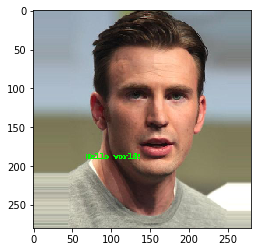

In [153]:
from PIL import ImageFont
from PIL import ImageDraw 


ImageDraw.Draw(
    img  # Image
).text(
    (68,182),  # Coordinates
    'Hello world!',  # Text
    (0, 255, 0)  # Color
)

plt.imshow(img)

In [50]:
import cv2
from cv2 import waitKey
from cv2 import destroyAllWindows
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
%matplotlib inline

font = cv2.FONT_HERSHEY_SIMPLEX

# load haar cascade classifier
haar = cv2.CascadeClassifier('./Pretrained_model/haarcascade_frontalface_default.xml')


In [21]:
# summarize some details about the image
print(img.format)
print(img.mode)
print(img.size)
# show the image
img.show()

None
RGB
(250, 250)


In [104]:
# convert an image from Pillow into cv image
open_cv_image = np.array(img)


In [52]:
# Convert from color into gray 

gray = cv2.cvtColor(open_cv_image,cv2.COLOR_BGR2GRAY)
gray.shape

(280, 280)

In [105]:
#img_data = asarray(img)
faces = haar.detectMultiScale(gray,1.5,5)
print(faces)

[[ 68  37 182 182]]


In [123]:
# Create rectange in the images
for x,y,w,h in faces:
    cv2.rectangle(gray, (0, int(IMG_SIZE)), (int(img.size[1]), int(IMG_SIZE)), (0, 255, 0), 5)
    #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
#plt.imshow(gray)


In [75]:
# Upload the model, including its weights and the optimizer

dir_pretrainedModel = "./Pretrained_model/my_model2.h5"
new_model2 = tf.keras.models.load_model(dir_pretrainedModel)



In [124]:
 class_names = ["female", "male"]
    # step-5: resize images (100,100)
if gray.shape[0] > 150:
    roi_resize = cv2.resize(gray,(150,150),cv2.INTER_AREA)
else:
    roi_resize = cv2.resize(gray,(150,150),cv2.INTER_CUBIC)
roi_resize = cv2.cvtColor(roi_resize, cv2.COLOR_GRAY2RGB)
img_array= tf.keras.utils.img_to_array(roi_resize)
img_array= tf.expand_dims(img_array,0) #create patch (I have just one
img_array = img_array/255

predictions= new_model2.predict(img_array)
#pred_accuracy = predictions
score_class = tf.nn.softmax(predictions[0])

print("The image is likely belong to {} with a {:.2f}% percent confidence.".format(class_names[int(score)], 100*float(predictions)))



The image is likely belong to male with a 71.75% percent confidence.


(-0.5, 279.5, 279.5, -0.5)

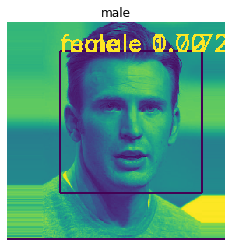

In [148]:
text = "%s : %0.2f"%(class_names[int(score_class)],predictions)
cv2.putText(gray,text,(x,y),font,1,(IMG_SIZE,IMG_SIZE,0),2)

plt.imshow(gray[:])
plt.title(class_names[int(score_class)])
plt.axis("off")


In [110]:


# step -10:
predict = predictions.argmax() # 0 or 1 
score = predictions[predict]
# step -11:
text = "%s : %0.2f"%(class_names[int(score)],score)
cv2.putText(gray,text,(x,y),font,1,(255,255,0),2)


array([[170, 170, 170, ..., 146, 146, 146],
       [170, 170, 170, ..., 143, 143, 143],
       [170, 170, 170, ..., 145, 145, 145],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [3]:
Tabnine::config 

SyntaxError: invalid syntax (<ipython-input-3-c6b1efcde0ea>, line 1)